In [2]:
# --- Setup and Imports ---
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import os

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
!pip -q install kaggle

import os
from google.colab import files

kaggle_dir = os.path.expanduser("~/.kaggle")
kaggle_json_path = os.path.join(kaggle_dir, "kaggle.json")

# Only ask for kaggle.json if it isn't already set up
if not os.path.exists(kaggle_json_path):
    print("kaggle.json not found. Please upload it now...")
    uploaded = files.upload()  # upload kaggle.json here

    # Create kaggle dir + move file into place
    os.makedirs(kaggle_dir, exist_ok=True)

    # If user uploaded with correct name, this will exist in cwd
    if "kaggle.json" not in uploaded and not os.path.exists("kaggle.json"):
        raise FileNotFoundError("Upload failed or kaggle.json not found. Make sure the file is named kaggle.json.")

    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("kaggle.json installed.")
else:
    print("kaggle.json already exists — skipping upload/setup.")

# Download + unzip dataset
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip -o brain-tumor-mri-dataset.zip -d data


kaggle.json not found. Please upload it now...


Streaming output truncated to the last 5000 lines.
  inflating: data/Training/glioma/Tr-gl_0712.jpg  
  inflating: data/Training/glioma/Tr-gl_0713.jpg  
  inflating: data/Training/glioma/Tr-gl_0714.jpg  
  inflating: data/Training/glioma/Tr-gl_0715.jpg  
  inflating: data/Training/glioma/Tr-gl_0716.jpg  
  inflating: data/Training/glioma/Tr-gl_0717.jpg  
  inflating: data/Training/glioma/Tr-gl_0718.jpg  
  inflating: data/Training/glioma/Tr-gl_0719.jpg  
  inflating: data/Training/glioma/Tr-gl_0720.jpg  
  inflating: data/Training/glioma/Tr-gl_0721.jpg  
  inflating: data/Training/glioma/Tr-gl_0722.jpg  
  inflating: data/Training/glioma/Tr-gl_0723.jpg  
  inflating: data/Training/glioma/Tr-gl_0724.jpg  
  inflating: data/Training/glioma/Tr-gl_0725.jpg  
  inflating: data/Training/glioma/Tr-gl_0726.jpg  
  inflating: data/Training/glioma/Tr-gl_0727.jpg  
  inflating: data/Training/glioma/Tr-gl_0728.jpg  
  inflating: data/Training/glioma/Tr-gl_0729.jpg  
  inflating: data/Training/glio

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Enhanced data generators with stronger augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,           # increased from 15
    width_shift_range=0.15,      # increased from 0.1
    height_shift_range=0.15,     # increased from 0.1
    zoom_range=0.2,              # increased from 0.1
    horizontal_flip=True,
    shear_range=0.15,            # added shear
    vertical_flip=False,         # medical images shouldn't flip vertically
    fill_mode='nearest',
    validation_split=0.2         # 20% for validation
)

# Test data generator - only rescaling, no augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = '/content/data/Training'

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical', # Changed from 'binary' to 'categorical'
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical', # Changed from 'binary' to 'categorical'
    subset='validation'
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


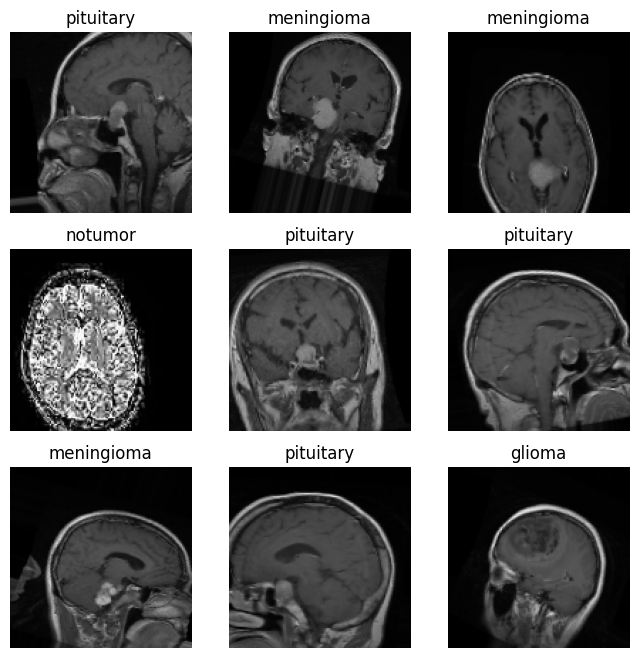

In [23]:
# --- Visualize sample images correctly ---
images, labels = next(train_gen)  # Get one batch of images and labels

# Get class names from the generator
class_names = list(train_gen.class_indices.keys())

plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    # Get the class index from the one-hot encoded label
    class_idx = np.argmax(labels[i])
    plt.title(class_names[class_idx]) # Display the actual class name
    plt.axis("off")
plt.show()

Training the dataset with the loaded data

In [76]:
# --- Optimized CNN Model Definition with Batch Normalization ---
from tensorflow.keras.regularizers import l2

model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.003)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.003)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),

    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    # Block 4 - Additional depth
    layers.Conv2D(192, (3, 3), activation='relu', kernel_regularizer=l2(0.005)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    # Fully Connected Layers
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=l2(0.005)),
    layers.BatchNormalization(),
    layers.Dropout(0.6),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.005)),
    layers.BatchNormalization(),
    layers.Dropout(0.6),
    layers.Dense(4, activation='softmax')
])

# Compile with optimized settings
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_105 (Conv2D)             │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_135         │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_106 (Conv2D)             │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_136         │ (None, 124, 124, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_137         │ (None, 60, 60, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_108 (Conv2D)             │ (None, 58, 58, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_138         │ (None, 58, 58, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_91 (Dropout)            │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_109 (Conv2D)             │ (None, 27, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_139         │ (None, 27, 27, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_110 (Conv2D)             │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_140         │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_92 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_111 (Conv2D)             │ (None, 10, 10, 192)    │       221,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_141         │ (None, 10, 10, 192)    │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ (None, 5, 5, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,774,948 (6.77 MB)

 Trainable params: 1,772,900 (6.76 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [77]:
# --- Model Training with Advanced Callbacks ---
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Calculate class weights to handle potential class imbalance
samples_per_class = train_gen.samples / len(train_gen.class_indices)
# Adjusted class_weight for 4 classes
class_weight = {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}  # adjust if you detect imbalance

# Callbacks for improved training
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_brain_tumor_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train with more epochs - early stopping will prevent overfitting
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,  # increased from 10 - early stopping will limit overfitting
    callbacks=callbacks,
    verbose=1,
    class_weight=class_weight
)

Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.4492 - loss: 6.3780
Epoch 1: val_accuracy improved from -inf to 0.25504, saving model to best_brain_tumor_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 55s 279ms/step - accuracy: 0.4497 - loss: 6.3751 - val_accuracy: 0.2550 - val_loss: 7.3954 - learning_rate: 0.0010
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.6091 - loss: 5.0480
Epoch 2: val_accuracy improved from 0.25504 to 0.25679, saving model to best_brain_tumor_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 194ms/step - accuracy: 0.6092 - loss: 5.0463 - val_accuracy: 0.2568 - val_loss: 8.9222 - learning_rate: 0.0010
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.7067 - loss: 4.0489
Epoch 3: val_accuracy improved from 0.25679 to 0.39001, saving model to best_brain_tumor_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 193ms/step - accuracy: 0.7066 - loss: 4.0477 - val_accuracy: 0.3900 - val_loss: 6.1979 - learning_rate: 0.0010
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.7188 - loss: 3.3795
Epoch 4: val_accuracy improved from 0.39001 to 0.41367, saving model to best_brain_tumor_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 194ms/step - accuracy: 0.7189 - loss: 3.3783 - val_accuracy: 0.4137 - val_loss: 4.7610 - learning_rate: 0.0010
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.7502 - loss: 2.8206
Epoch 5: val_accuracy improved from 0.41367 to 0.52761, saving model to best_brain_tumor_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 194ms/step - accuracy: 0.7503 - loss: 2.8196 - val_accuracy: 0.5276 - val_loss: 3.2684 - learning_rate: 0.0010
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.7771 - loss: 2.3565
Epoch 6: val_accuracy did not improve from 0.52761
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 191ms/step - accuracy: 0.7772 - loss: 2.3557 - val_accuracy: 0.5048 - val_loss: 3.1444 - learning_rate: 0.0010
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.8088 - loss: 1.9965
Epoch 7: val_accuracy improved from 0.52761 to 0.54864, saving model to best_brain_tumor_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 193ms/step - accuracy: 0.8089 - loss: 1.9961 - val_accuracy: 0.5486 - val_loss: 2.8272 - learning_rate: 0.0010
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8254 - loss: 1.7543
Epoch 8: val_accuracy did not improve from 0.54864
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 192ms/step - accuracy: 0.8254 - loss: 1.7539 - val_accuracy: 0.5434 - val_loss: 2.8336 - learning_rate: 0.0010
Epoch 9/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8286 - loss: 1.5921
Epoch 9: val_accuracy did not improve from 0.54864
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 192ms/step - accuracy: 0.8287 - loss: 1.5917 - val_accuracy: 0.4987 - val_loss: 2.7069 - learning_rate: 0.0010
Epoch 10/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8302 - loss: 1.4581
Epoch 10: val_accuracy improved from 0.54864 to 0.70026, saving model to best_brain_tumor_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 194ms/step - accuracy: 0.8303 - loss: 1.4577 - val_accuracy: 0.7003 - val_loss: 1.6403 - learning_rate: 0.0010
Epoch 11/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.8536 - loss: 1.2967
Epoch 11: val_accuracy improved from 0.70026 to 0.70114, saving model to best_brain_tumor_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 192ms/step - accuracy: 0.8536 - loss: 1.2967 - val_accuracy: 0.7011 - val_loss: 1.6790 - learning_rate: 0.0010
Epoch 12/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8454 - loss: 1.2782
Epoch 12: val_accuracy did not improve from 0.70114
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 192ms/step - accuracy: 0.8455 - loss: 1.2780 - val_accuracy: 0.6705 - val_loss: 1.6640 - learning_rate: 0.0010
Epoch 13/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8650 - loss: 1.1398
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: val_accuracy did not improve from 0.70114
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 193ms/step - accuracy: 0.8649 - loss: 1.1400 - val_accuracy: 0.4724 - val_loss: 2.5232 - learning_rate: 0.0010
Epoch 14/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8640 - loss: 1.0858
Epoch 14: val_accuracy improved from 0.70114 to 0.71429, saving model to best_brain_tumor_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 194ms/step - accuracy: 0.8641 - loss: 1.0855 - val_accuracy: 0.7143 - val_loss: 1.3545 - learning_rate: 5.0000e-04
Epoch 15/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8845 - loss: 0.9342
Epoch 15: val_accuracy improved from 0.71429 to 0.79492, saving model to best_brain_tumor_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 194ms/step - accuracy: 0.8845 - loss: 0.9342 - val_accuracy: 0.7949 - val_loss: 1.1122 - learning_rate: 5.0000e-04
Epoch 16/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8876 - loss: 0.8946
Epoch 16: val_accuracy did not improve from 0.79492
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 192ms/step - accuracy: 0.8876 - loss: 0.8945 - val_accuracy: 0.7344 - val_loss: 1.2373 - learning_rate: 5.0000e-04
Epoch 17/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8851 - loss: 0.8767
Epoch 17: val_accuracy did not improve from 0.79492
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 192ms/step - accuracy: 0.8851 - loss: 0.8767 - val_accuracy: 0.6100 - val_loss: 1.5573 - learning_rate: 5.0000e-04
Epoch 18/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8761 - loss: 0.9133
Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 18: val_accuracy did not improve from 0.79492
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 192ms/step - accuracy:

143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 193ms/step - accuracy: 0.8850 - loss: 0.8402 - val_accuracy: 0.8300 - val_loss: 0.9869 - learning_rate: 2.5000e-04
Epoch 20/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9143 - loss: 0.7482
Epoch 20: val_accuracy did not improve from 0.82997
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 192ms/step - accuracy: 0.9142 - loss: 0.7483 - val_accuracy: 0.7082 - val_loss: 1.2530 - learning_rate: 2.5000e-04
Epoch 21/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9105 - loss: 0.7309
Epoch 21: val_accuracy did not improve from 0.82997
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 192ms/step - accuracy: 0.9105 - loss: 0.7307 - val_accuracy: 0.7257 - val_loss: 1.3265 - learning_rate: 2.5000e-04
Epoch 22/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9057 - loss: 0.7172
Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 22: val_accuracy did not improve from 0.82997
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 192ms/step - accuracy:

143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 193ms/step - accuracy: 0.9088 - loss: 0.6976 - val_accuracy: 0.8545 - val_loss: 0.8650 - learning_rate: 1.2500e-04
Epoch 24/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9312 - loss: 0.6312
Epoch 24: val_accuracy did not improve from 0.85451
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 192ms/step - accuracy: 0.9311 - loss: 0.6312 - val_accuracy: 0.7809 - val_loss: 1.0045 - learning_rate: 1.2500e-04
Epoch 25/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9191 - loss: 0.6292
Epoch 25: val_accuracy did not improve from 0.85451
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 192ms/step - accuracy: 0.9191 - loss: 0.6293 - val_accuracy: 0.8501 - val_loss: 0.8060 - learning_rate: 1.2500e-04
Epoch 26/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9206 - loss: 0.6310
Epoch 26: val_accuracy improved from 0.85451 to 0.86328, saving model to best_brain_tumor_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 194ms/step - accuracy: 0.9206 - loss: 0.6309 - val_accuracy: 0.8633 - val_loss: 0.7630 - learning_rate: 1.2500e-04
Epoch 27/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9208 - loss: 0.6018
Epoch 27: val_accuracy did not improve from 0.86328
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 193ms/step - accuracy: 0.9209 - loss: 0.6017 - val_accuracy: 0.8598 - val_loss: 0.7916 - learning_rate: 1.2500e-04
Epoch 28/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9359 - loss: 0.5815
Epoch 28: val_accuracy did not improve from 0.86328
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 191ms/step - accuracy: 0.9358 - loss: 0.5816 - val_accuracy: 0.8563 - val_loss: 0.7905 - learning_rate: 1.2500e-04
Epoch 29/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9155 - loss: 0.6127
Epoch 29: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 29: val_accuracy did not improve from 0.86328
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 191ms/step - accuracy: 

143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 193ms/step - accuracy: 0.9313 - loss: 0.5484 - val_accuracy: 0.8869 - val_loss: 0.6801 - learning_rate: 6.2500e-05
Epoch 31/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9453 - loss: 0.5253
Epoch 31: val_accuracy did not improve from 0.88694
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 192ms/step - accuracy: 0.9453 - loss: 0.5253 - val_accuracy: 0.8869 - val_loss: 0.6793 - learning_rate: 6.2500e-05
Epoch 32/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9374 - loss: 0.5367
Epoch 32: val_accuracy improved from 0.88694 to 0.88782, saving model to best_brain_tumor_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 193ms/step - accuracy: 0.9375 - loss: 0.5366 - val_accuracy: 0.8878 - val_loss: 0.7083 - learning_rate: 6.2500e-05
Epoch 33/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9388 - loss: 0.5288
Epoch 33: val_accuracy improved from 0.88782 to 0.89483, saving model to best_brain_tumor_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 193ms/step - accuracy: 0.9388 - loss: 0.5287 - val_accuracy: 0.8948 - val_loss: 0.6391 - learning_rate: 6.2500e-05
Epoch 34/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9402 - loss: 0.5126
Epoch 34: val_accuracy did not improve from 0.89483
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 192ms/step - accuracy: 0.9402 - loss: 0.5126 - val_accuracy: 0.8563 - val_loss: 0.7937 - learning_rate: 6.2500e-05
Epoch 35/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9466 - loss: 0.4951
Epoch 35: val_accuracy did not improve from 0.89483
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 192ms/step - accuracy: 0.9466 - loss: 0.4952 - val_accuracy: 0.8703 - val_loss: 0.7556 - learning_rate: 6.2500e-05
Epoch 36/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9481 - loss: 0.4885
Epoch 36: val_accuracy did not improve from 0.89483
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 193ms/step - accuracy: 0.9481 - loss: 0.4886 - val_accuracy: 0.8931 - val_loss: 0.6237 - learning_ra

143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 193ms/step - accuracy: 0.9426 - loss: 0.4783 - val_accuracy: 0.9027 - val_loss: 0.6053 - learning_rate: 3.1250e-05
Epoch 41/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9578 - loss: 0.4492
Epoch 41: val_accuracy improved from 0.90272 to 0.90622, saving model to best_brain_tumor_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 193ms/step - accuracy: 0.9577 - loss: 0.4493 - val_accuracy: 0.9062 - val_loss: 0.5912 - learning_rate: 3.1250e-05
Epoch 42/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9442 - loss: 0.4724
Epoch 42: val_accuracy did not improve from 0.90622
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 197ms/step - accuracy: 0.9442 - loss: 0.4724 - val_accuracy: 0.8992 - val_loss: 0.5806 - learning_rate: 3.1250e-05
Epoch 43/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9555 - loss: 0.4399
Epoch 43: val_accuracy did not improve from 0.90622
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 192ms/step - accuracy: 0.9555 - loss: 0.4399 - val_accuracy: 0.8975 - val_loss: 0.6144 - learning_rate: 3.1250e-05
Epoch 44/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9534 - loss: 0.4393
Epoch 44: val_accuracy did not improve from 0.90622
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 193ms/step - accuracy: 0.9534 - loss: 0.4393 - val_accuracy: 0.8983 - val_loss: 0.5820 - learning_ra

143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 194ms/step - accuracy: 0.9632 - loss: 0.4153 - val_accuracy: 0.9115 - val_loss: 0.5649 - learning_rate: 1.5625e-05
Epoch 48/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9569 - loss: 0.4243
Epoch 48: val_accuracy did not improve from 0.91148
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 193ms/step - accuracy: 0.9569 - loss: 0.4243 - val_accuracy: 0.9062 - val_loss: 0.5702 - learning_rate: 1.5625e-05
Epoch 49/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9645 - loss: 0.4248
Epoch 49: val_accuracy improved from 0.91148 to 0.91586, saving model to best_brain_tumor_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 194ms/step - accuracy: 0.9644 - loss: 0.4248 - val_accuracy: 0.9159 - val_loss: 0.5369 - learning_rate: 1.5625e-05
Epoch 50/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9605 - loss: 0.4096
Epoch 50: val_accuracy did not improve from 0.91586
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 194ms/step - accuracy: 0.9605 - loss: 0.4096 - val_accuracy: 0.9115 - val_loss: 0.5742 - learning_rate: 1.5625e-05
Restoring model weights from the end of the best epoch: 49.


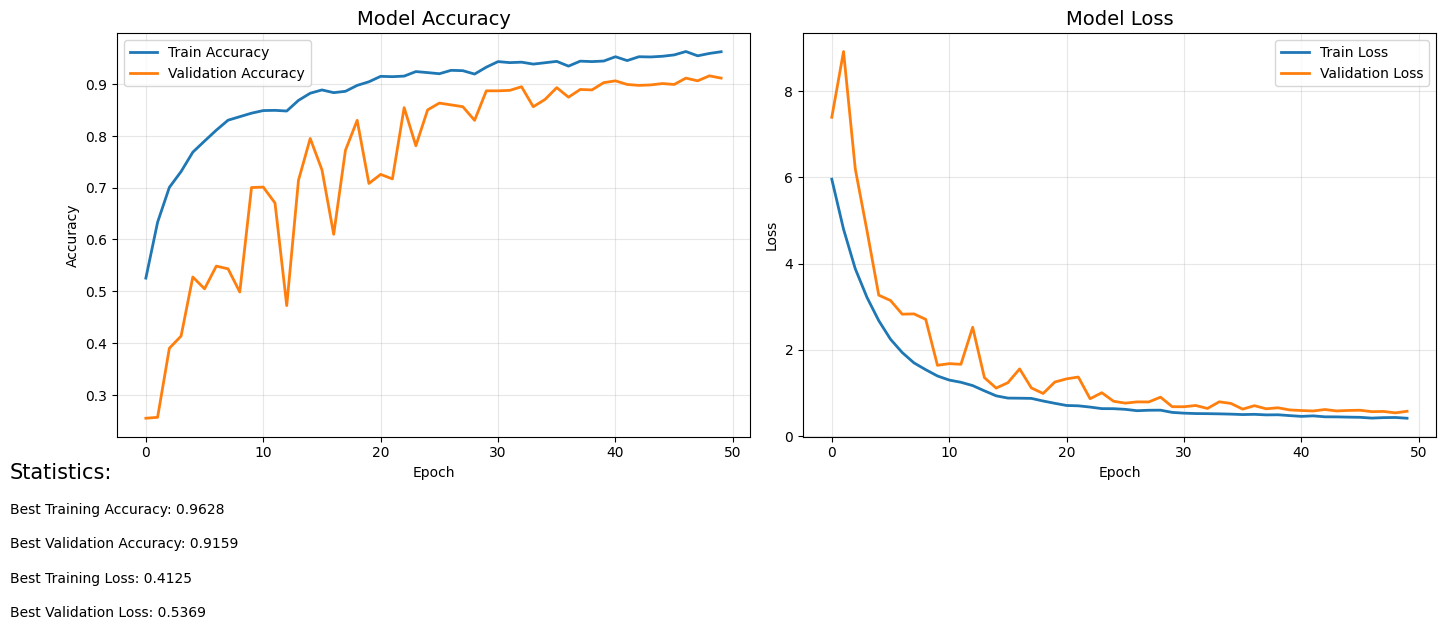


Training Summary:
Final Train Accuracy: 0.9624
Final Validation Accuracy: 0.9115
Final Train Loss: 0.4125
Final Validation Loss: 0.5742


Best Train Accuracy: 0.9628
Best Validation Accuracy: 0.9159
Best Train Loss: 0.4125
Best Validation Loss: 0.5369


Total Epochs Trained: 50


In [85]:
# --- Plot Training Results with Detailed Analysis ---
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()

plt.text(-70, -1, "Statistics:", fontsize=15)
plt.text(-70,-1.8,f"Best Training Accuracy: {max(history.history['accuracy']):.4f}")
plt.text(-70,-2.6,f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
plt.text(-70,-3.4,f"Best Training Loss: {min(history.history['loss']):.4f}")
plt.text(-70,-4.2,f"Best Validation Loss: {min(history.history['val_loss']):.4f}")
plt.show()

# Print summary
print(f"\nTraining Summary:")
print(f"Final Train Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Train Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print("\n")
print(f"Best Train Accuracy: {max(history.history['accuracy']):.4f}")
print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Best Train Loss: {min(history.history['loss']):.4f}")
print(f"Best Validation Loss: {min(history.history['val_loss']):.4f}")
print("\n")
print(f"Total Epochs Trained: {len(history.history['accuracy'])}")

In [86]:
# --- Save Models and Evaluation ---
# Save the final trained model
model.save('brain_tumor_cnn_model_final.h5')
print("Final model saved as 'brain_tumor_cnn_model_final.h5'")

# The best model is already saved by ModelCheckpoint callback
print("Best model saved as 'best_brain_tumor_model.h5' (highest validation accuracy)")

# Load and evaluate the best model
from tensorflow.keras.models import load_model
best_model = load_model('best_brain_tumor_model.h5')

print("\n--- Best Model Performance ---")
eval_results = best_model.evaluate(val_gen)
print(f"Validation Accuracy: {eval_results[1]:.4f}")
print(f"Validation Loss: {eval_results[0]:.4f}")

Final model saved as 'brain_tumor_cnn_model_final.h5'
Best model saved as 'best_brain_tumor_model.h5' (highest validation accuracy)



--- Best Model Performance ---
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - accuracy: 0.9152 - loss: 0.5437
Validation Accuracy: 0.9211
Validation Loss: 0.5279
